In [1]:
import nltk

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [ ]:
from nltk import nltk.corpus
import stopwords

In [26]:
# 분석용 데이터를 DB에서 내려 받아 데이터프레임을 구성

import psycopg2
import pandas as pd

connection = psycopg2.connect(host="localhost", dbname="dvdrental", user="postgres", password="0328", port=5432)

cur = connection.cursor()

cur.execute("select * from KSAT_Sent")
rows = cur.fetchall()

df2 = pd.DataFrame(rows)
df2.columns=['sid','raw_data','year', 'grammars', 'version']
df2.head()

,sid,raw_data,year,grammars,version
0,1,ahah haha,2052,n/a,0.1
1,2,BFB5BEEE5FC2A62E687770 1 8 1 17.,2021,n/a,0.3
2,3,"National Baking Competition ,.",2021,n/a,0.3
3,4,Reusable Straw Sets 3 pieces Set Material Pric...,2021,n/a,0.3
4,5,How about going to the cafe over there? I don ...,2021,n/a,0.3


In [25]:
df.groupby('year').size()

year
2021    257
2022    246
2023    473
dtype: int64

In [27]:
df2.groupby('year').size()

year
2021    514
2022    246
2023    473
2052      1
dtype: int64

In [8]:
## 영어문장 작업결과 입력 테이블 생성

import psycopg2
import pandas as pd

connection = psycopg2.connect(host="localhost", dbname="dvdrental", user="postgres", password="0328", port=5432)

cur = connection.cursor()

sql_string = "CREATE TABLE IF NOT EXISTS KSAT_Sent2 (sid SERIAL, raw_data TEXT, year VARCHAR(5), grammars VARCHAR(200), version VARCHAR(10))"

cur.execute(sql_string)

cur.execute("commit")
sql_string = "INSERT INTO KSAT_Sent2 (raw_data, year, version) VALUES ('dummy insert', '2052', '0.2')"

cur.execute(sql_string)

cur.execute("commit")

# 입력 잘 되었는지 확인
cur.execute("select * from KSAT_Sent2")
rows = cur.fetchall()
rows

[(1, 'dummy insert', '2052', None, '0.2'),
 (2, 'dummy insert', '2052', None, '0.2'),
 (3, 'dummy insert', '2052', None, '0.2')]

In [9]:
import os

filelist = os.listdir("D:/ENG/")
filelist

['2021_영어.pdf', '2022_영어.pdf', '2023_영어.pdf']

In [11]:
from tika import parser 
import re

year_list =[]
sent_list = []

for file in filelist:

    # 파일 제목에서 연도 추출
    year = re.findall(r'\d+', file)[0]
    
    path="D:/ENG/" + file
    raw = parser.from_file(path) #메모리 관리 측면에서 그리 효율적이지는 않은 접근

    # 1차 정제 및 분할
    cleansed = re.sub('[^A-Za-z0-9,.?!;\'\"]+',' ', raw['content'])
    result = cleansed.split(".")

    # 파일별로 split 된 문장들의 길이만큼 연도, 문장을 각 리스트로 생성
    for i in range(len(result)):
        year_list.append(year)
        sent_list.append(result[i])

raw_df = pd.DataFrame({'year': year_list, 'raw_data':sent_list})
raw_df.head()

2022-12-14 09:22:23,811 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


,year,raw_data
0,2021,BFB5BEEE5FC2A62E687770 1 8 1 17
1,2021,"1 15 , 16 17"
2,2021,
3,2021,1
4,2021,","


In [12]:
raw_df

,year,raw_data
0,2021,BFB5BEEE5FC2A62E687770 1 8 1 17
1,2021,"1 15 , 16 17"
2,2021,
3,2021,1
4,2021,","
...,...,...
1528,2023,Hailey Camila
1529,2023,
1530,2023,
1531,2023,


In [13]:
work_version='0.4'

for i in range(len(raw_df)): #복제할 테이블 길이만큼만 반복

    # df 각 row에서 value 추출 및 변수에 할당
    each_year = raw_df['year'][i]
    raw_text = raw_df['raw_data'][i]

    sql_string = "INSERT INTO KSAT_Sent2 (raw_data, year, version) VALUES ('{}', '{}', '{}')".format(raw_text, each_year, work_version)

    cur.execute(sql_string)

cur.execute("commit")

In [14]:
import psycopg2
import pandas as pd

connection = psycopg2.connect(host="localhost", dbname="dvdrental", user="postgres", password="0328", port=5432)

cur = connection.cursor()

cur.execute("select * from KSAT_Sent2 where version='0.4'")
rows = cur.fetchall()

sentences_df = pd.DataFrame(rows)
sentences_df.columns=['sid','raw_data','year', 'grammars', 'version']
sentences_df.head()

,sid,raw_data,year,grammars,version
0,4,BFB5BEEE5FC2A62E687770 1 8 1 17,2021,None,0.4
1,5,"1 15 , 16 17",2021,None,0.4
2,6,,2021,None,0.4
3,7,1,2021,None,0.4
4,8,",",2021,None,0.4


In [16]:
sentences_df['raw_data'] = sentences_df['raw_data'].apply(lambda x: x.strip())
sentences_df['raw_data'] = sentences_df['raw_data'].apply(lambda x: x+'.')
def sent_Checker1(text):
    
    # 영문장 조건에 맞도록 정규식 함수
    # 첫문자: 영문 대문자
    # 끝문자: 마침표

    pattern1 = '^[A-Z].*\.$' 

    if re.search(pattern1,  text):
        return True

    else:
        return False


In [18]:
sentences_df['Checker'] = sentences_df['raw_data'].apply(lambda x: 1 if sent_Checker1(x) else 0)

sentences_df.head()

,sid,raw_data,year,grammars,version,Checker
0,4,BFB5BEEE5FC2A62E687770 1 8 1 17..,2021,None,0.4,1
1,5,"1 15 , 16 17..",2021,None,0.4,0
2,6,..,2021,None,0.4,0
3,7,1..,2021,None,0.4,0
4,8,",..",2021,None,0.4,0


In [19]:
valid_sent = sentences_df[sentences_df['Checker']==1]

# 문자길이 계산
valid_sent['letter_cnt'] = valid_sent['raw_data'].apply(lambda x: len(x))

# 단어길이 계산(단순 띄어쓰기 기준)
valid_sent['word_cnt'] = valid_sent['raw_data'].apply(lambda x: len(x.split()))

valid_sent.head()

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3274020739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_sent['letter_cnt'] = valid_sent['raw_data'].apply(lambda x: len(x))
C:\Users\user\AppData\Local\Temp\ipykernel_25248\3274020739.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_sent['word_cnt'] = valid_sent['raw_data'].apply(lambda x: len(x.split()))


,sid,raw_data,year,grammars,version,Checker,letter_cnt,word_cnt
0,4,BFB5BEEE5FC2A62E687770 1 8 1 17..,2021,None,0.4,1,33,5
25,29,"National Baking Competition ,..",2021,None,0.4,1,31,4
33,37,Reusable Straw Sets 3 pieces Set Material Pric...,2021,None,0.4,1,88,15
40,44,How about going to the cafe over there? I don ...,2021,None,0.4,1,75,16
41,45,Why didn t you wear more comfortable shoes? Yo...,2021,None,0.4,1,81,15


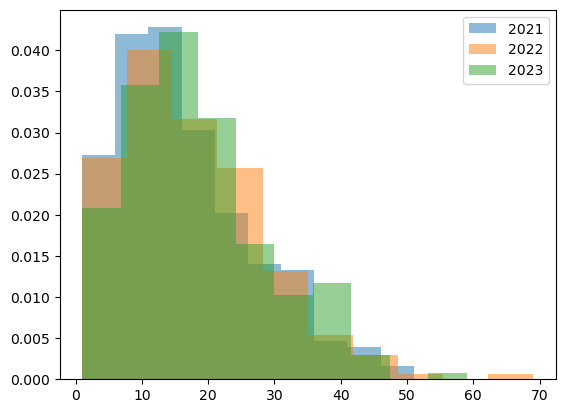

TypeError: 'module' object is not callable

In [20]:
import matplotlib as pyplot
import matplotlib.pyplot as plt

len2021 = valid_sent[valid_sent['year']=='2021']['word_cnt']
len2022 = valid_sent[valid_sent['year']=='2022']['word_cnt']
len2023 = valid_sent[valid_sent['year']=='2023']['word_cnt']

# valid_sent[valid_sent['year']=='2021']['word_cnt'].hist(alpha=0.5, label='2021')
# valid_sent[valid_sent['year']=='2022']['word_cnt'].hist(alpha=0.5, label='2022')
# valid_sent[valid_sent['year']=='2023']['word_cnt'].hist(alpha=0.5, label='2023')


plt.hist(len2021, alpha=0.5, label='2021', density=True)
plt.hist(len2022, alpha=0.5, label='2022', density=True)
plt.hist(len2023, alpha=0.5, label='2023', density=True)
plt.legend(loc='upper right')
plt.show()

pyplot.legend(loc='upper right')

In [28]:
valid_sent

,sid,raw_data,year,grammars,version,Checker,letter_cnt,word_cnt
0,4,BFB5BEEE5FC2A62E687770 1 8 1 17..,2021,None,0.4,1,33,5
25,29,"National Baking Competition ,..",2021,None,0.4,1,31,4
33,37,Reusable Straw Sets 3 pieces Set Material Pric...,2021,None,0.4,1,88,15
40,44,How about going to the cafe over there? I don ...,2021,None,0.4,1,75,16
41,45,Why didn t you wear more comfortable shoes? Yo...,2021,None,0.4,1,81,15
...,...,...,...,...,...,...,...,...
1520,1524,"He walked in joyfully, hugging his daughters..",2023,None,0.4,1,46,7
1521,1525,"They all walked into the dining room, where he...",2023,None,0.4,1,117,21
1523,1527,A ? B D C C B D C D B D B C D C B 44..,2023,None,0.4,1,38,18
1527,1531,Hailey..,2023,None,0.4,1,8,1


In [31]:
from nltk import sent_tokenize, word_tokenize

In [32]:
sent_tokenize(s)
[word_tokenize]

NameError: name 's' is not defined

In [43]:
# word_tokens = word_tokenize(text)
# sent_tokens = sent_tokenize(text)

valid_sent['word_cnt_tk'] = valid_sent['raw_data'].apply(lambda x: len(word_tokenize(x)))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3366185574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_sent['word_cnt_tk'] = valid_sent['raw_data'].apply(lambda x: len(word_tokenize(x)))


In [44]:
valid_sent

,sid,raw_data,year,grammars,version,Checker,letter_cnt,word_cnt,word_cnt_tk
0,4,BFB5BEEE5FC2A62E687770 1 8 1 17..,2021,None,0.4,1,33,5,6
25,29,"National Baking Competition ,..",2021,None,0.4,1,31,4,5
33,37,Reusable Straw Sets 3 pieces Set Material Pric...,2021,None,0.4,1,88,15,16
40,44,How about going to the cafe over there? I don ...,2021,None,0.4,1,75,16,18
41,45,Why didn t you wear more comfortable shoes? Yo...,2021,None,0.4,1,81,15,17
...,...,...,...,...,...,...,...,...,...
1520,1524,"He walked in joyfully, hugging his daughters..",2023,None,0.4,1,46,7,9
1521,1525,"They all walked into the dining room, where he...",2023,None,0.4,1,117,21,23
1523,1527,A ? B D C C B D C D B D B C D C B 44..,2023,None,0.4,1,38,18,19
1527,1531,Hailey..,2023,None,0.4,1,8,1,2


In [ ]:
from tika import parser 
import re

year_list =[]
sent_list = []

for file in filelist:

    # 파일 제목에서 연도 추출
    year = re.findall(r'\d+', file)[0]
    
    path="D:/ENG/" + file
    raw = parser.from_file(path) #메모리 관리 측면에서 그리 효율적이지는 않은 접근

    # 1차 정제 및 분할
    cleansed = re.sub('[^A-Za-z0-9,.?!;\'\"]+',' ', raw['content'])
    result = cleansed.split(".")

    # 파일별로 split 된 문장들의 길이만큼 연도, 문장을 각 리스트로 생성
    for i in range(len(result)):
        year_list.append(year)
        sent_list.append(result[i])

raw_df = pd.DataFrame({'year': year_list, 'raw_data':sent_list})
raw_df.head()

In [78]:
import os

path = "D:/ENG/"
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.pdf')]

df = pd.DataFrame()
j = 0

for i in file_list_py:
    raw = parser.from_file(path+i)
    cleansed = re.sub('[^A-Za-z0-9,.?!;\'\"]+',' ', raw['content'])
    
    result = sent_tokenize(cleansed)
    raw_split = pd.DataFrame({'raw_data':result})
    raw_split['year'] = 2021+j
    j += 1
    
    df = pd.concat([df,raw_split])

In [79]:
df

,raw_data,year
0,BFB5BEEE5FC2A62E687770 1 8 1 17 .,2021
1,"1 15 , 16 17 . . 1. , .",2021
2,"2. , . . . . . . 3. , .",2021
3,"4. , .",2021
4,"5. , .",2021
...,...,...
644,B D C C B D C D B D B C D C B 44. a e ?,2023
645,a b c d e 45. ?,2023
646,Hailey . . Hailey .,2023
647,Hailey Camila .,2023


In [56]:
df.head(100)

,raw_data,year
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,2021
1,"1번부터 \n\n15번까지는 한 번만 들려주고, 16번부터 17번까지는 두 번 \n...",2021
2,방송을 잘 듣고 답을 하시기 바랍니다.,2021
3,1.,2021
4,"다음을 듣고, 남자가 하는 말의 목 으로 가장 한 것을 \n\n고르시오.",2021
...,...,...
95,Our \ndonation booths are located in the lobbi...,2021
96,Just drop off the items there during usual lib...,2021
97,The donated food should be \nnon-perishable li...,2021
98,Packaged \ngoods such as jam and peanut butter...,2021


In [73]:
def sent_Checker(text):

    pattern1 = '^[A-Z]' 

    if re.search(pattern1,  text):
        return True

    else:
        return False

In [74]:
df['Checker'] = df['raw_data'].apply(lambda x: 1 if sent_Checker(x) else 0)

In [75]:
df

,raw_data,year,Checker
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,2021,0
1,"1번부터 \n\n15번까지는 한 번만 들려주고, 16번부터 17번까지는 두 번 \n...",2021,0
2,방송을 잘 듣고 답을 하시기 바랍니다.,2021,0
3,1.,2021,0
4,"다음을 듣고, 남자가 하는 말의 목 으로 가장 한 것을 \n\n고르시오.",2021,0
...,...,...,...
776,④ Hailey와 Camila는 아버지의 집을 방문하 다.,2023,0
777,⑤ 아버지는 자신의 나이와 같은 수의 장미를 받았다.,2023,0
778,* 확인 사항\n\n◦답안지의 해당란에 필요한 내용을 정확히 기입(표기)했는지 확인...,2023,0
779,이 문제지에 관한 저작권은 한국교육과정평가원에 있습니다.,2023,0


In [66]:
df['raw_data'][99]

99    We will \ndistribute the food to our neighbors...
99    I am sure the lecture will help our teachers m...
99                      I look forward \nto your reply.
Name: raw_data, dtype: object

In [76]:
df2 = df[df['Checker'] == 1]

In [64]:
df2.iloc[:50]

,raw_data,year,Checker
43,I’ll bring your car over here.,2021,1
45,I’ll choose another car instead.,2021,1
47,Then I’ll park somewhere else.,2021,1
49,I’ll pay the parking fee later.,2021,1
51,I don’t want my car to be painted.,2021,1
56,I’m glad that you bought the displayed one.,2021,1
58,Call me when my washing machine is repaired.,2021,1
60,It’s too bad you don’t sell the displayed model.,2021,1
62,The displayed one may be the best option for me.,2021,1
64,I don’t think I can wait until tomorrow for th...,2021,1


In [77]:
df2

,raw_data,year,Checker
25,"National Baking Competition에 한 다음 내용을 듣고, 일치하지...",2021,1
33,Reusable Straw Sets (3 pieces)\n\nSet Material...,2021,1
43,I’ll bring your car over here.,2021,1
45,I’ll choose another car instead.,2021,1
47,Then I’ll park somewhere else.,2021,1
...,...,...,...
761,"In reply, Hailey answered, “No.",2023,1
762,I bought something \nmuch more personal.,2023,1
763,"By the way, there’s something (e) you \nshould...",2023,1
764,It was their dad and they were \noverjoyed to ...,2023,1


In [81]:
df2.groupby('year').size()

year
2021    198
2022    181
2023    352
dtype: int64

In [85]:
df2['word'] = df2['raw_data'].apply(lambda x: len(word_tokenize(x)))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3283847707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['word'] = df2['raw_data'].apply(lambda x: len(word_tokenize(x)))


In [98]:
df2

,raw_data,year,Checker,word
25,"National Baking Competition에 한 다음 내용을 듣고, 일치하지...",2021,1,13
33,Reusable Straw Sets (3 pieces)\n\nSet Material...,2021,1,54
43,I’ll bring your car over here.,2021,1,9
45,I’ll choose another car instead.,2021,1,8
47,Then I’ll park somewhere else.,2021,1,8
...,...,...,...,...
761,"In reply, Hailey answered, “No.",2023,1,9
762,I bought something \nmuch more personal.,2023,1,7
763,"By the way, there’s something (e) you \nshould...",2023,1,27
764,It was their dad and they were \noverjoyed to ...,2023,1,12


In [102]:
type(df['year'].iloc[1])

numpy.int64

In [88]:
import numpy as np
import pandas as pd
from nltk import nltk.corpus
import stopwords

SyntaxError: invalid syntax (1981449240.py, line 3)

In [89]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 8.9 MB/s eta 0:00:00


In [103]:
# 2022년 영어문장(Checker=1, 또는 valid_sent DF에서 추출) 값을 하나로 모을 변수
word_string = [] 

sents_2022 = df2[df2['year']==2022]['raw_data']

# 아래는 index 에러, DF 분리 과정에 index가 잘리기 때문
for sent in sents_2022:
    word_string.append(sent)

word_string

word_string= ' '.join(word_string)

word_string

'Study Rooms\n\nRoom\nCapacity\n(persons)\n\nAvailable Times\nPrice\n\n(per hour)\nProjector\n\n① A 2-3 9 a.m.— 11 a.m. $10 ☓\n② B 4-6 9 a.m.— 11 a.m. $16 ◯\n③ C 4-6 2 p.m.— 4 p.m. $14 ☓\n④ D 6-8 2 p.m.— 4 p.m. $19 ◯\n⑤ E 6-9 4 p.m.— 6 p.m. $21 ☓\n\n11. That’s too expensive for the repair. Thanks for taking those pictures of me. I’ll drop off the camera tomorrow. I’ll stop by and get it on my way home. I like the camera you bought for me. Let’s enjoy ourselves at the exhibition with the kids. That’ll be a good way to take time for yourself. Stress is not always as bad as you think. Woman:\n① Please check it again. The hotel can’t be fully booked. I should’ve checked out as early as possible. I’m very satisfied with your cleaning service. You can’t switch your room with mine. That’s high enough to avoid the smell. I can get the job done before the deadline. Let’s meet to discuss the changes to the sculpture. I’m sorry that the reopening was postponed. You have to send the final design i

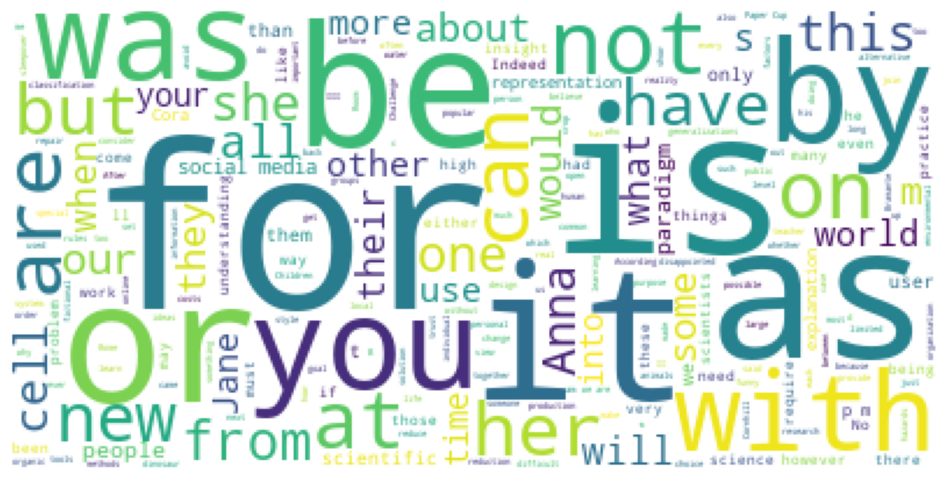

In [105]:
## 퀵하게 워드클라우드를 그려보자

import numpy as np
import pandas as pd
# import nltk from nltk.corpus
# import stopwords

stopwords = ['yo', 'yea', 'hey', 'The', 'the', 'and', 'that', 'a', 'an', 'of', 'i', 'to', 'in']

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words=300).generate(word_string)

plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [108]:
# nltk로 품사 분석하기
# Needs 1: 유효한 영어문장인지 식별을 위해 동사 포함여부를 확인하고 싶어졌음
# Needs 2: 워드클라우드 등 분석 과정에 품사별로 나눠서 데이터를 보고 싶어짐


import nltk
test_str = 'You must get to the airport quickly.'

text = tokenize.word_tokenize(test_str)
tagged = nltk.pos_tag(text)

In [107]:
text

['You', 'must', 'get', 'to', 'the', 'airport', 'quickly', '.']

In [109]:
tagged

[('You', 'PRP'),
 ('must', 'MD'),
 ('get', 'VB'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('airport', 'NN'),
 ('quickly', 'RB'),
 ('.', '.')]

In [115]:
tagged[2][1]

'VB'

In [122]:
def check_verb(str):
    text = tokenize.word_tokenize(str)
    tagged = nltk.pos_tag(text)
    
    for i in range(len(tagged)):
        x = tagged[i][1]
        if x == 'VB':
            return 1
        else:
            return 0

In [124]:
df2['check_verb'] = df2['raw_data'].apply(lambda x: check_verb(x))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3948080913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['check_verb'] = df2['raw_data'].apply(lambda x: check_verb(x))


In [126]:
df2[df2['check_verb'] == 1]

,raw_data,year,Checker,word,check_verb
58,Call me when my washing machine is repaired.,2021,1,9,1
171,"Ask a \nfriend to cup his hand, palm face up, ...",2021,1,17,1
231,Visit our web site at www.eypcap.com to register.,2021,1,9,1
362,"Put more generally, the \nparable of the ant i...",2021,1,36,1
56,Let’s enjoy ourselves at the exhibition with t...,2022,1,12,1
80,Let’s meet to discuss the changes to the sculp...,2022,1,12,1
210,Let’s save the earth together!,2022,1,8,1
48,Let’s go and look at his career options together.,2023,1,12,1
63,Try to memorize words by learning the root words.,2023,1,10,1
346,Make a Checklist Just in Case\n⑤ How Human Jud...,2023,1,14,1


In [127]:
df2

,raw_data,year,Checker,word,check_verb
25,"National Baking Competition에 한 다음 내용을 듣고, 일치하지...",2021,1,13,0
33,Reusable Straw Sets (3 pieces)\n\nSet Material...,2021,1,54,0
43,I’ll bring your car over here.,2021,1,9,0
45,I’ll choose another car instead.,2021,1,8,0
47,Then I’ll park somewhere else.,2021,1,8,0
...,...,...,...,...,...
761,"In reply, Hailey answered, “No.",2023,1,9,0
762,I bought something \nmuch more personal.,2023,1,7,0
763,"By the way, there’s something (e) you \nshould...",2023,1,27,0
764,It was their dad and they were \noverjoyed to ...,2023,1,12,0


In [133]:
df2['raw_data'][763]

'By the way, there’s something (e) you \nshould know about Dad...” They were suddenly interrupted \nby the doorbell ringing.'

In [153]:
## valid_sent 데이터프레임의 각 raw_data에 동사가 있는지 없는지 확인하는 sentence checker2 작성

# verb counting 체커
def sent_Checker2(txt):
    
    # 동사가 포함되었는지 확인하는 기능 구현

    tokens = tokenize.word_tokenize(txt)
    tagged = nltk.pos_tag(tokens)
    
    vb_counter = 0 # 동사 개수 집계
    
    for tag in tagged:
        if tag[1]=='VB' or 'VBP': 
            if tag[1] == 'TO':
                vb_counter +=1

    if vb_counter>0:

        return 1

    else:
        return 0
    
# 탐색적 검사 결과, VB의 다양한 변형()

In [154]:
df2['check_verb2'] = df2['raw_data'].apply(lambda x: sent_Checker2(x))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\2208717685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['check_verb2'] = df2['raw_data'].apply(lambda x: sent_Checker2(x))


In [155]:
df2

,raw_data,year,Checker,word,check_verb,check_verb2
25,"National Baking Competition에 한 다음 내용을 듣고, 일치하지...",2021,1,13,0,0
33,Reusable Straw Sets (3 pieces)\n\nSet Material...,2021,1,54,0,0
43,I’ll bring your car over here.,2021,1,9,0,0
45,I’ll choose another car instead.,2021,1,8,0,0
47,Then I’ll park somewhere else.,2021,1,8,0,0
...,...,...,...,...,...,...
761,"In reply, Hailey answered, “No.",2023,1,9,0,0
762,I bought something \nmuch more personal.,2023,1,7,0,0
763,"By the way, there’s something (e) you \nshould...",2023,1,27,0,0
764,It was their dad and they were \noverjoyed to ...,2023,1,12,0,1


In [157]:
df2[df2['check_verb2'] == 1]

,raw_data,year,Checker,word,check_verb,check_verb2
51,I don’t want my car to be painted.,2021,1,11,0,1
68,It was the best ceremony I’ve ever been to.,2021,1,12,0,1
70,I want to go to congratulate him myself.,2021,1,9,0,1
74,You deserve to receive the award.,2021,1,7,0,1
94,You can bring your items for donation to our b...,2021,1,11,0,1
...,...,...,...,...,...,...
727,"For example, algorithms have proved more (a) a...",2023,1,45,0,1
732,Using \nchecklists to ensure that no crucial s...,2023,1,34,0,1
747,Seeing vivid red and green \ncolors for the fi...,2023,1,17,0,1
759,"He’s kept it a secret so \nas not to worry us,...",2023,1,18,0,1


In [ ]:
정규식활용 대문자 시작 마침표 종료 필터 (CHECKER1)
동사 원형 + 변형 포함 필터 (CHECKER3)
CHECKER1과 CHECKER3 (LAST_CHECK)

In [ ]:
print("tag리스트의 형:", type(tagged))
print("tag리스트 각 값의 형:", type(tagged[0]))
print(tagged[0]) # 하나의 단어-품사 세트(튜플) 출력
print(tagged[0][0]) # 0번 단어-품사 세트 튜플에서 단어 값 출력
print(tagged[0][1]) # 0번 단어-품사 세트 튜플에서 품사 값 출력

In [ ]:
sentences_df['Checker2'] = sentences_df['raw_data'].apply(lambda x: 1 if sent_Checker2(x) else 0)

sentences_df.head()

In [ ]:
print("정규식활용:", len(sentences_df[sentences_df['Checker']==1]))
print("동사포함필터:", len(sentences_df[sentences_df['Checker2']==1]))

In [ ]:
## nitrogen fertilizer manure legume 31 34 . 이게 동사 포함으로 분석되지만, 이상함. nltk 기본 pos tag 의 한계

test_str = sentences_df[sentences_df['sid']==3595]['raw_data'].values[0]
print("원문:", test_str)

text = tokenize.word_tokenize(test_str)
print("단어토큰:", text)

tagged = nltk.pos_tag(text)
print("품사태깅:", tagged)

In [ ]:
# Checker1 과 Checker3 모두 충족되는 문장만 분석대상으로 삼기로 한다.

sentences_df['LastCheck'] = sentences_df.apply(lambda row: 1 if row['Checker']+row['Checker3']==2 else 0, axis=1)

#집계로 확인
print("정규식활용 필터(Checker):", len(sentences_df[sentences_df['Checker']==1]))
print("동사 원형+변형 포함 필터(Checker3):", len(sentences_df[sentences_df['Checker3']==1]))
print("동사 원형+변형 포함 필터(LastCheck):", len(sentences_df[sentences_df['LastCheck']==1]))

In [ ]:
# LastCheck = 1 인 문장들을 기준으로 To 부정사 포함 문장을 태깅하자
# tag[1]의 값이 'TO' 다음에 'VB' 'VBP'가 이어지는 경우 --> 1 로 태깅, 아닌 경우는 0으로 표시

## 연도별 TO 부정사 포함 문장의 비율을 계산하자.

In [170]:
x = len(df2[(df2['check_verb2'] == 1) & (df2['year'] == 2021)]) / len(df2[df2['check_verb2'] == 1]) * 100
y = len(df2[(df2['check_verb2'] == 1) & (df2['year'] == 2022)]) / len(df2[df2['check_verb2'] == 1]) * 100
z = len(df2[(df2['check_verb2'] == 1) & (df2['year'] == 2023)]) / len(df2[df2['check_verb2'] == 1]) * 100

print(round(x), '%')
print(round(y), '%')
print(round(z), '%')

24 %
24 %
52 %


In [161]:
3 / 100 * 100

3.0

In [166]:
df2[(df2['check_verb2'] == 1) & (df2['year'] == 2022)]

,raw_data,year,Checker,word,check_verb,check_verb2
59,That’ll be a good way to take time for yourself.,2022,1,13,0,1
74,That’s high enough to avoid the smell.,2022,1,10,0,1
80,Let’s meet to discuss the changes to the sculp...,2022,1,12,1,1
84,You have to send the final design immediately.,2022,1,9,0,1
96,We are interested in learning how to teach onl...,2022,1,12,0,1
...,...,...,...,...,...,...
358,"We’re \nthrilled to have you back!” Then, Jane...",2022,1,35,0,1
361,"Cora was a new \nmember, whom Anna had persona...",2022,1,16,0,1
364,"When she received \nit, Cora thanked her and p...",2022,1,41,0,1
368,Why \ndon’t you forget about her?” Anna replie...,2022,1,39,0,1


In [171]:
# 품사 값이 'TO' 다음에 'VB' 또는 'VBP' 가 이어지는 경우 --> 1 로 태깅, 아닌 경우는 0으로 표시
# Pos(Part of Speech) Tagging 관련 위키: https://en.wikipedia.org/wiki/Part-of-speech_tagging


# 접근 방법 1. pos_tagged_list(단어, 품사 리스트) 컬럼 추가 후 각 리스트에서 반복문으로 스캔
 
# import nltk

# 태그정보 컬럼 추가
df2['pos_tags'] = df2['raw_data'].apply(lambda x: nltk.pos_tag(tokenize.word_tokenize(x)))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3761351705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pos_tags'] = df2['raw_data'].apply(lambda x: nltk.pos_tag(tokenize.word_tokenize(x)))


In [172]:
# To 부정사 식별

def extract_pos_tags(tag_list):

    for i in range(len(tag_list)):

        # 현재 튜플의 품사값이 'TO'인지 확인
        # 원문의 값이 아닌 품사 태그의 TO를 뜻함. 인덱스 확인.
        # 튜플[0]=원문의 스트링값, 튜플[1]=품사태그
        if tag_list[i][1] == 'TO':

            #마지막 튜플이 아니라면, 그 다음 튜플의 품사값이 동사인지 확인
            if i!=(len(tag_list)-1):
                if tag_list[i+1][1] == 'VB' or tag_list[i+1][1] == 'VBP':

                    return(True)
        
        else:
            continue

    return(False)

# 태그정보 컬럼 추가
df2['to_vb'] = df2['pos_tags'].apply(lambda x: extract_pos_tags(x))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\910277793.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['to_vb'] = df2['pos_tags'].apply(lambda x: extract_pos_tags(x))


In [173]:
# 접근 방법 2. pos_tagged_list(단어, 품사 리스트)에서 품사만 추출해서 스트링으로 만들어서 컬럼 추가 후, re.search 활용

def only_pos_tags(data):

    text = tokenize.word_tokenize(data)

    tagged = nltk.pos_tag(text)

    only_tags =""

    for pos in tagged:
        only_tags += str(pos[1])+"_"

    return(only_tags)

df2['only_tags'] = df2['raw_data'].apply(lambda x: only_pos_tags(x))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\3422911207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['only_tags'] = df2['raw_data'].apply(lambda x: only_pos_tags(x))


In [174]:
# only_tags 컬럼(스트링)에서 "TO_VB" 또는 "TO_VBP" 를 포함하는지 검색

def to_vb_finder(data):

    if "TO_VB" in data or "TO_VBP" in data: 
        return(True)
    
    else: 
        return(False)

df2['to_vb_2'] = df2['only_tags'].apply(lambda x: to_vb_finder(x))

C:\Users\user\AppData\Local\Temp\ipykernel_25248\358982894.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['to_vb_2'] = df2['only_tags'].apply(lambda x: to_vb_finder(x))


In [ ]:
## 연도별 To 부정사 포함 문장의 비율을 계산하자.

In [175]:
df2

,raw_data,year,Checker,word,check_verb,check_verb2,pos_tags,to_vb,only_tags,to_vb_2
25,"National Baking Competition에 한 다음 내용을 듣고, 일치하지...",2021,1,13,0,0,"[(National, NNP), (Baking, NNP), (Competition에...",False,"NNP_NNP_NNP_NNP_NNP_NNP_NNP_,_NNP_NNP_NNP_NNP_._",False
33,Reusable Straw Sets (3 pieces)\n\nSet Material...,2021,1,54,0,0,"[(Reusable, JJ), (Straw, NNP), (Sets, NNP), ((...",False,JJ_NNP_NNP_(_CD_NNS_)_NNP_NNP_NNP_NNP_(_NNS_)_...,False
43,I’ll bring your car over here.,2021,1,9,0,0,"[(I, PRP), (’, VBP), (ll, JJ), (bring, VB), (y...",False,PRP_VBP_JJ_VB_PRP$_NN_IN_RB_._,False
45,I’ll choose another car instead.,2021,1,8,0,0,"[(I, PRP), (’, VBP), (ll, JJ), (choose, VB), (...",False,PRP_VBP_JJ_VB_DT_NN_RB_._,False
47,Then I’ll park somewhere else.,2021,1,8,0,0,"[(Then, RB), (I, PRP), (’, VBP), (ll, JJ), (pa...",False,RB_PRP_VBP_JJ_NN_RB_RB_._,False
...,...,...,...,...,...,...,...,...,...,...
761,"In reply, Hailey answered, “No.",2023,1,9,0,0,"[(In, IN), (reply, NN), (,, ,), (Hailey, NNP),...",False,"IN_NN_,_NNP_VBD_,_JJ_NNP_._",False
762,I bought something \nmuch more personal.,2023,1,7,0,0,"[(I, PRP), (bought, VBD), (something, NN), (mu...",False,PRP_VBD_NN_RB_RBR_JJ_._,False
763,"By the way, there’s something (e) you \nshould...",2023,1,27,0,0,"[(By, IN), (the, DT), (way, NN), (,, ,), (ther...",False,"IN_DT_NN_,_EX_NNP_NN_NN_(_NN_)_PRP_MD_VB_IN_NN...",False
764,It was their dad and they were \noverjoyed to ...,2023,1,12,0,1,"[(It, PRP), (was, VBD), (their, PRP$), (dad, N...",True,PRP_VBD_PRP$_NN_CC_PRP_VBD_VBN_TO_VB_PRP_._,True


In [176]:
x = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2021)]) / len(df2[df2['to_vb_2'] == 1]) * 100
y = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2022)]) / len(df2[df2['to_vb_2'] == 1]) * 100
z = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2023)]) / len(df2[df2['to_vb_2'] == 1]) * 100

print(round(x), '%')
print(round(y), '%')
print(round(z), '%')

24 %
25 %
52 %


In [189]:
df2[df2['to_vb_2'] == True]

,raw_data,year,Checker,word,check_verb,check_verb2,pos_tags,to_vb,only_tags,to_vb_2
51,I don’t want my car to be painted.,2021,1,11,0,1,"[(I, PRP), (don, VBP), (’, JJ), (t, NN), (want...",True,PRP_VBP_JJ_NN_VBP_PRP$_NN_TO_VB_VBN_._,True
70,I want to go to congratulate him myself.,2021,1,9,0,1,"[(I, PRP), (want, VBP), (to, TO), (go, VB), (t...",True,PRP_VBP_TO_VB_TO_VB_PRP_PRP_._,True
74,You deserve to receive the award.,2021,1,7,0,1,"[(You, PRP), (deserve, VBP), (to, TO), (receiv...",True,PRP_VBP_TO_VB_DT_NN_._,True
107,I had to run out of \nthe concert hall to sett...,2021,1,13,0,1,"[(I, PRP), (had, VBD), (to, TO), (run, VB), (o...",True,PRP_VBD_TO_VB_RB_IN_DT_NN_NN_TO_VB_RP_._,True
110,And the way to win is to figure out who you ar...,2021,1,22,0,1,"[(And, CC), (the, DT), (way, NN), (to, TO), (w...",True,CC_DT_NN_TO_VB_VBZ_TO_VB_RP_WP_PRP_VBP_CC_VBP_...,True
111,I had no reason to oppose \nmy friend.,2021,1,9,0,1,"[(I, PRP), (had, VBD), (no, DT), (reason, NN),...",True,PRP_VBD_DT_NN_TO_VB_PRP$_NN_._,True
121,The \nexpertise that we work hard to acquire i...,2021,1,28,0,1,"[(The, DT), (expertise, NN), (that, IN), (we, ...",True,DT_NN_IN_PRP_VBP_RB_TO_VB_IN_CD_NN_MD_VB_IN_RB...,True
122,"In the end, as much as we may want to become \...",2021,1,30,0,1,"[(In, IN), (the, DT), (end, NN), (,, ,), (as, ...",True,"IN_DT_NN_,_RB_JJ_IN_PRP_MD_VB_TO_VB_NNS_IN_NN_...",True
137,Environmental journalists have to play the rol...,2021,1,16,0,1,"[(Environmental, JJ), (journalists, NNS), (hav...",True,JJ_NNS_VBP_TO_VB_DT_NN_IN_DT_NNP_NN_NNP_NN_NNS...,True
138,They have to put across the point of view of t...,2021,1,19,0,1,"[(They, PRP), (have, VBP), (to, TO), (put, VB)...",True,PRP_VBP_TO_VB_IN_DT_NN_IN_NN_IN_DT_NN_TO_NNS_W...,True


In [182]:
df_mask = df2[(df2['to_vb'] != True) & (df2['to_vb_2'] == True)]

In [193]:
import pandas as pd
print("pandas version: ", pd.__version__)

pandas version:  1.4.4


In [198]:
import pandas as pd
pd.set_option('display.width', 100000)

In [208]:
df_mask # TO_VBG_XX

,raw_data,year,Checker,word,check_verb,check_verb2,pos_tags,to_vb,only_tags,to_vb_2
291,Humor reframes \npotentially divisive events i...,2021,1,26,0,1,"[(Humor, NNP), (reframes, VBZ), (potentially, ...",False,NNP_VBZ_RB_JJ_NNS_IN_RB_JJ_JJ_NN_NNS_WDT_VBP_V...,True
383,"This time, (c) the playful and \ncurious boy w...",2021,1,29,0,1,"[(This, DT), (time, NN), (,, ,), ((, (), (c, N...",False,"DT_NN_,_(_NN_)_DT_JJ_CC_JJ_NN_VBD_JJ_IN_PRP$_N...",True
100,I am looking forward to hearing from you.,2022,1,9,0,1,"[(I, PRP), (am, VBP), (looking, VBG), (forward...",False,PRP_VBP_VBG_NN_TO_VBG_IN_PRP_._,True
262,Elinor Ostrom found that there are several fac...,2022,1,22,0,1,"[(Elinor, NNP), (Ostrom, NNP), (found, VBD), (...",False,NNP_NNP_VBD_IN_EX_VBP_JJ_NNS_JJ_TO_VBG_IN_JJ_J...,True
272,The narrowing of our consciousness of time \ns...,2023,1,33,0,1,"[(The, DT), (narrowing, NN), (of, IN), (our, P...",False,DT_NN_IN_PRP$_NN_IN_NN_NNS_DT_NN_TO_VBG_PRP_IN...,True
662,The narrowing of our consciousness of time \ns...,2023,1,33,0,1,"[(The, DT), (narrowing, NN), (of, IN), (our, P...",False,DT_NN_IN_PRP$_NN_IN_NN_NNS_DT_NN_TO_VBG_PRP_IN...,True


In [201]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [205]:
print(df_mask['raw_data'].iloc[:6])

291    Humor reframes \npotentially divisive events i...
383    This time, (c) the playful and \ncurious boy w...
100            I am looking forward to hearing from you.
262    Elinor Ostrom found that there are several fac...
272    The narrowing of our consciousness of time \ns...
662    The narrowing of our consciousness of time \ns...
Name: raw_data, dtype: object


In [200]:
pd.describe_option()

compute.use_bottleneck : bool
    Use the bottleneck library to accelerate if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
compute.use_numba : bool
    Use the numba engine option for select operations if it is installed,
    the default is False
    Valid values: False,True
    [default: False] [currently: False]
compute.use_numexpr : bool
    Use the numexpr library to accelerate computation if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]
display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]
display.column_space No description available.
    [defa

In [203]:
import numpy as np #numpy library
np.set_printoptions(threshold=np.inf, linewidth=np.inf) #inf = infinity 

In [206]:
df_mask['raw_data'].iloc[:6]

291    Humor reframes \npotentially divisive events i...
383    This time, (c) the playful and \ncurious boy w...
100            I am looking forward to hearing from you.
262    Elinor Ostrom found that there are several fac...
272    The narrowing of our consciousness of time \ns...
662    The narrowing of our consciousness of time \ns...
Name: raw_data, dtype: object

In [207]:
pd.set_option('display.max_rows', None)

In [ ]:
x = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2021)]) / len(df2[df2['to_vb_2'] == 1]) * 100
y = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2022)]) / len(df2[df2['to_vb_2'] == 1]) * 100
z = len(df2[(df2['to_vb_2'] == 1) & (df2['year'] == 2023)]) / len(df2[df2['to_vb_2'] == 1]) * 100


In [221]:
round(122/352*100)

35

In [216]:
len(df2[df2['year'] == 2023])

352

In [225]:
df_vb = pd.DataFrame([[2021, 198, 56, round(56/198*100)],
                    [2022, 181, 58, round(58/181*100)],
                    [2023, 352, 122, round(122/352*100)]],
                    columns = ['연도', '전체 문장수', 'To_VB 문장수', 'To_VB(%)'])

In [226]:
df_vb

,연도,전체 문장수,To_VB 문장수,To_VB(%)
0,2021,198,56,28
1,2022,181,58,32
2,2023,352,122,35


In [ ]:
## 연도별 To 부정사 포함(to_vb 또는 to_vb_2 중 하나 선택) 비율을 계산하자.

years_list=sentences_df['year'].unique()
total_sent=[]
to_vb_sent=[]
#to_vb 비율은 DF 생성 후에 apply로 연산

for oneyear in years_list:

    that_year_total = len(sentences_df[(sentences_df['year']==oneyear) & (sentences_df['LastCheck']==1)])
    that_year_tobe = len(sentences_df[(sentences_df['year']==oneyear) & (sentences_df['LastCheck']==1) & (sentences_df['to_vb']==1)])

    total_sent.append(that_year_total)
    to_vb_sent.append(that_year_tobe)


report_df = pd.DataFrame({'year': years_list, 'total_sent':total_sent, 'to_do':to_vb_sent})
report_df['to_do_perc'] = report_df.apply(lambda rows: rows['to_do']/rows['total_sent'], axis=1)
report_df

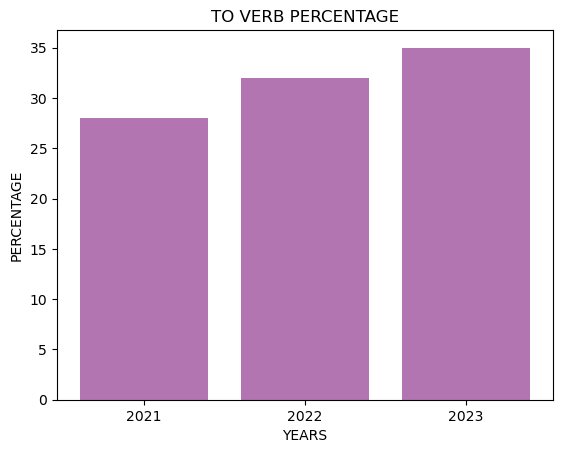

In [227]:
# import matplotlib.pyplot as plt

x=df_vb['연도']
y=df_vb['To_VB(%)']
bars=df_vb['연도']

plt.bar(x, y, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('TO VERB PERCENTAGE')
plt.xlabel('YEARS')
plt.ylabel('PERCENTAGE')
 
# Create names on the x axis
plt.xticks(x, bars)
 
# Show graph
plt.show()